In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [93]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [94]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [95]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [96]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 2.03374043e-01],
         [-1.63998437e+00],
         [-8.26069117e-01],
         ...,
         [-9.38276589e-01],
         [-7.69573092e-01],
         [ 7.50215292e-01]],

        [[ 5.29461324e-01],
         [ 5.49754798e-01],
         [-4.10646498e-01],
         ...,
         [-4.67149645e-01],
         [-5.37665904e-01],
         [ 8.77852142e-01]],

        [[ 3.10086787e-01],
         [ 2.78066218e-01],
         [ 2.96745952e-02],
         ...,
         [-1.01093531e+00],
         [-3.86761218e-01],
         [ 6.52473986e-01]],

        ...,

        [[-9.73215818e-01],
         [-5.47093928e-01],
         [ 1.03910303e+00],
         ...,
         [ 1.16967821e+00],
         [-1.48980284e+00],
         [ 5.10794520e-01]],

        [[-7.15654373e-01],
         [-7.50505924e-01],
         [ 8.27613235e-01],
         ...,
         [-1.34171093e+00],
         [ 7.28761613e-01],
         [-4.46021795e-01]],

      

In [97]:
noise_factor = 0.3 #IT21109126: Use optimal noise_factor value (When noise_factor >= 0.4, harder for AE to learn, thus leading to greater loss)
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [98]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

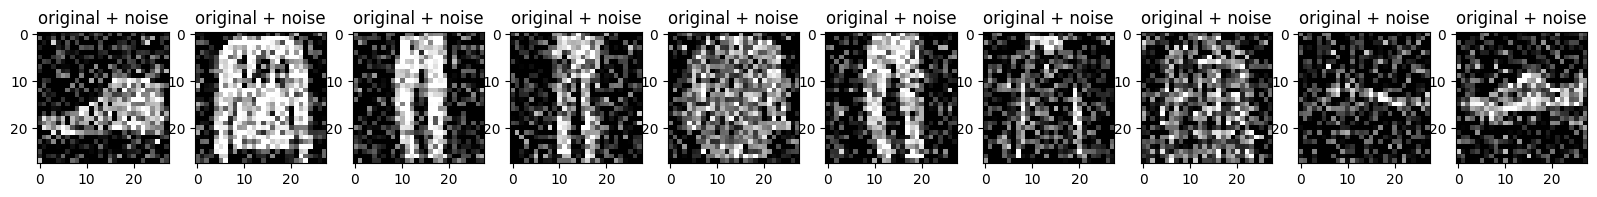

In [99]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [100]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [101]:
autoencoder = Denoise()

In [102]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [103]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30, # IT21109126: Train for 30 epochs
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0375 - val_loss: 0.0133
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 12/30
1875/1875 ━━━━━━━

In [104]:
autoencoder.encoder.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
autoencoder.decoder.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_10                  │ (32, 14, 14, 8)             │             584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (32, 28, 28, 16)            │           1,168 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

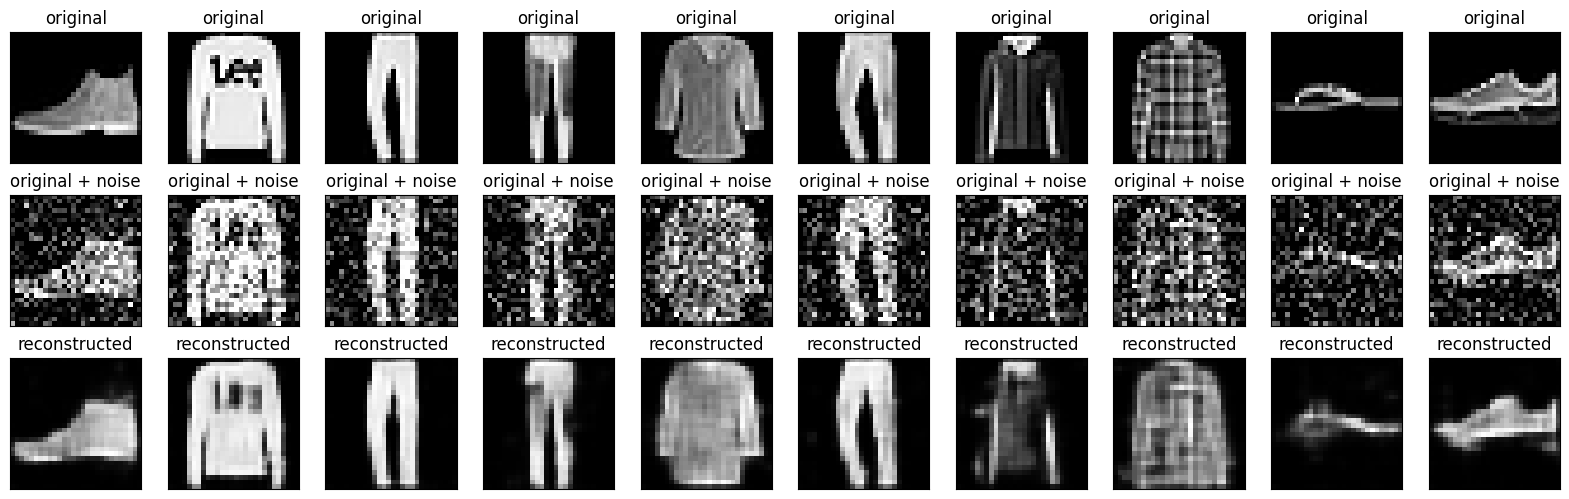

In [107]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## IT21109126: Mean Squared Error for Test Dataset

In [108]:
# 1. Make predictions on the test data
reconstructed_images = autoencoder.predict(x_test_noisy)

# 2. Calculate the MSE
mse = np.mean(np.square(x_test - reconstructed_images)) # Using the original x_test here

# 3. Print the MSE
print(f"Mean Squared Error on Test Data: {mse}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error on Test Data: 0.009759100154042244


## IT21109126: Plot the train and validation loss against number of epochs

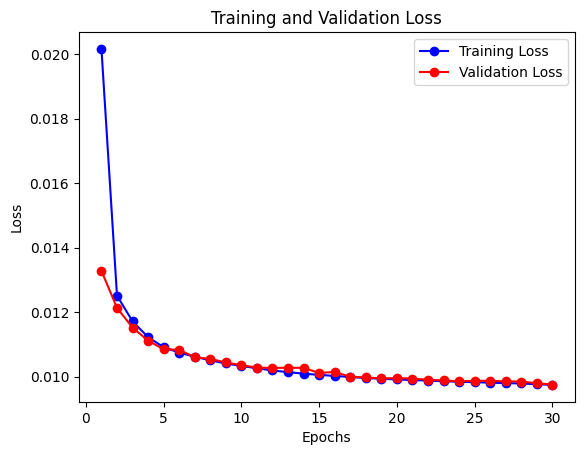

In [109]:
# Extract the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
epochs = range(1, len(train_loss) + 1)  # Epochs start from 1

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()